---
title: "CS546 - Class Session 14 - Partial Correlation Network"
author: "Trent VanHawkins"
date: today
format: 
    pdf:
        geometry: "margin=0.75in"
        mathspec: true
        code-overflow: wrap
        cap-location: bottom
        tbl-cap-location: bottom
        header-includes: 
        - \usepackage{fancyhdr, amsthm, amssymb,amsfonts,amsthm, amsmath, bbm}
        - \usepackage{float, tabularx}
        - \floatplacement{table}{H}
        - \pagestyle{fancy}
        - \fancyhead[R]{Notebook 14}
        - \fancyhead[L]{Trent VanHawkins}
        - \fancyfoot[C]{\thepage} # Center page number at bottom of each page
page-layout: full
execute: 
  eval: true
---


In this class session we will continue with analyzing the tumor gene expression dataset from the NIH human bladder cancer cohort (*M*=414 tumors), building on what we learned in Class Session 13 (Correlation Network).  In order to keep the analysis simple&ast;, in this notebook will restrict our analysis to a set of *N*=164 genes that are very highly expressed in bladder cancer. Using the 164&nbsp;✖️&nbsp;414 matrix of transcript abundance measurements, we will construct a network based on gene-gene partial correlation coefficients. We will also compare the distribution of partial correlation coefficients to the distribution of Pearson correlation coefficients. Do you think they will be different?  In what way would you expect them to be different?

&ast; Here, "simple" means that the covariance matrix will be nonsingular, so that we can obtain the partial correlation matrix by inversion.

We'll import all of the python modules that we will need for this exercise

In [37]:
import pandas as pd  ## data file loading
import numpy as np
import matplotlib.pyplot as plt
import sklearn.covariance, scipy.stats, math
import igraph  ## for network visualization and finding components

Download the file https://csx46.s3-us-west-2.amazonaws.com/bladder_cancer_genes_tcga.txt to the local file `bladder_cancer_genes_tcga.txt`

In [38]:
!curl https://csx46.s3-us-west-2.amazonaws.com/bladder_cancer_genes_tcga.txt > ../DataRaw/bladder_cancer_genes_tcga.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  26.2M      0  0:00:01  0:00:01 --:--:-- 26.2M


Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples). (use Pandas, `pandas.read.csv`, and `as_matrix`). As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414) using `shape`.

In [39]:
gene_matrix_for_network_df = pd.read_csv("../DataRaw/bladder_cancer_genes_tcga.txt", sep="\t", index_col=0)
gene_matrix_for_network_df.head()

,X01a589db.02d8.4d75.a2da.bb0bd8140a32,X05126c55.410a.4450.8e88.3b0fa9e49b14,X06e30c48.0b24.46e5.8876.8209ea65d704,X088a8d3a.1884.4d14.93a2.66df2ff47628,X08d22dc8.4e6e.11e4.8601.f8dbfc308db6,X08e56050.4e6e.11e4.8601.f8dbfc308db6,X08ecf95a.4e6e.11e4.8601.f8dbfc308db6,X08fd4da0.4e6e.11e4.8601.f8dbfc308db6,X0909ebf0.4e6e.11e4.8601.f8dbfc308db6,X0915d19a.4e6e.11e4.8601.f8dbfc308db6,...,fa8a383a.efaa.492b.a87c.a926e912dc74,fc17d473.11ba.4aac.8e4d.673aa6f0d4ad,fc979f24.d173.46bd.a30a.9f376e1febbd,fd13aa2f.da45.43b7.bfeb.d65f5b7db76b,fd8c9f9c.2ad7.496e.a5ba.cfc4ecaaf276,fe4973d6.8cc7.4cf2.9de0.634060c1a27d,fe9a2c56.f153.4a6a.80a8.7c76fc3399c8,fea0bcf7.0c01.4612.a548.5aa7a8cf98ea,fec4dd5f.b484.4a05.b176.94f261d41e58,ff92b1db.f373.4d62.8d54.1e59613de084
ENSG00000234188,4.278637,6.760906,6.124157,7.235445,3.629256,1.767787,4.551253,6.456134,0.713452,5.215922,...,7.156419,9.067313,2.692988,6.879562,0.006648,6.283693,0.003328,0.019854,6.676600,0.045908
ENSG00000186847,6.800840,13.929602,17.016735,15.509375,4.327498,6.137541,8.044546,9.130559,9.426429,6.871816,...,17.387704,9.540287,5.245207,6.833211,8.289966,6.283693,7.434291,11.905898,6.309085,5.333377
ENSG00000123500,6.515281,9.655202,8.566063,9.484565,6.568698,4.343260,7.955002,8.727535,3.592164,7.001262,...,9.609262,12.350076,3.552815,9.664088,0.006648,8.916290,4.007684,3.399440,9.399588,2.220487
ENSG00000170373,3.605227,2.653288,5.504165,5.338904,3.864515,4.936733,3.734256,5.122317,3.805211,1.984086,...,9.440471,9.589385,12.486760,4.354461,0.006648,7.523354,5.928988,7.722740,6.106326,9.902810
ENSG00000159217,3.117910,2.319260,8.959835,0.006648,2.725089,1.347685,6.575666,0.036193,2.141511,2.457310,...,0.036193,3.934828,1.910662,7.516592,3.574373,0.688860,2.994576,0.019854,4.743738,7.079750


Convert your data frame to a numpy matrix, using the `pandas.DataFrame.values` attribute.

In [40]:
gene_matrix_for_network = gene_matrix_for_network_df.values

As always, sanity check that the file that you loaded has the expected dimensions (4,473 x 414) using `shape`.

In [41]:
gene_matrix_for_network.shape

(4473, 414)

Compute the median expression level for each row of your matrix

In [42]:
genes_median_expression = np.median(gene_matrix_for_network, axis=1)

Filter the matrix to include only rows for which the gene's median expression is > 12; matrix should now be 164 x 414; this will enable us to easily compute the partial correlation matrix using the inverse of the covariance matrix. Print the size of the filtered matrix, as a sanity check.

In [43]:
gene_matrix_np = gene_matrix_for_network
genes_keep = genes_median_expression > 12
matrix_filt = gene_matrix_np[genes_keep, :]
N = matrix_filt.shape[0]
print(f"Number of genes kept: {N}")

Number of genes kept: 164


Print the shape of your filtered matrix, as a sanity check.  It should be 164x414 (164 genes by 414 tumor samples).

In [44]:
matrix_filt.shape

(164, 414)

Compute the 164 x 164 matrix of gene-gene Pearson correlation coefficients, using `numpy.corrcoef` (this function treats each *row* as a random variable, so you don't have to do any transposing of the matrix, unlike the situation in R).

In [45]:
matrix_cor = np.corrcoef(matrix_filt)

Compute the sample covariance matrix using `sklearn.covariance.empirical_covariance` (from the `sklearn.covariance` package, . Make sure you take the transpose of the `matrix_filt` matrix before passing it to the `empirical_covariance` function.

In [46]:
matrix_cov = sklearn.covariance.empirical_covariance(np.matrix.transpose(matrix_filt))

Check if `matrix_cov` is nonsingular by using `numpy.linalg.matrix_rank`. (Note: if we could do numerically exact arithmetic on the matrix, we could instead compute the determinant and check if it is nonzero, but when we are using floating-point arithmetic, in practice we wind up with a super-small number for the determinant, and it is difficult to assess whether that small number is meaningfully different from zero). Is the sample covariance matrix full rank?

In [47]:
np.linalg.matrix_rank(matrix_cov)

np.int64(164)

Use `numpy.linalg.inv` to get the sample precision matrix as the multiplicative inverse of the sample covariance matrix. (NOTE: we can only do this using `numpy.linalg.inv` in cases where the covariance matrix is nonsingular, which we arranged by selecting fewer genes than there are tumor samples in the dataset from which the sample covariance matrix was computed).

In [48]:
matrix_cov_inv = np.linalg.inv(matrix_cov)

Recall from today's lecture that the full partial correlation matrix is the negative of the sample precision matrix, with each (i,j) entry rescaled by the square root of the sample variance of variable i and the sample variance of variable j. Use a double for loop to "scale" the negative of the precision matrix, which will give you the partial correlation. Print the dimensions of the matrix you get back, as a sanity check.

In [49]:
matrix_pcor = -matrix_cov_inv
for i in range(N):
    for j in range(N):
        matrix_pcor[i,j] /= np.sqrt(matrix_cov_inv[i,i]*matrix_cov_inv[j,j])
print(matrix_pcor.shape)

(164, 164)


Get the correlation coefficients and the partial correlation coefficients of the lower triangle of the matrix (not including the diagonal), as two vectors `cor_values` and `pcor_values`; your resulting vectors should each have length 13,366.  You will want to use `numpy.tri` and `numpy.where` (see class session 13 exercise)

In [50]:
cor_values = matrix_cor[np.where(np.tri(*matrix_cor.shape, k=-1))]
pcor_values = matrix_pcor[np.where(np.tri(*matrix_pcor.shape, k=-1))]
print(len(cor_values))
print(len(pcor_values))

13366
13366


plot the histograms of the correlation coefficients (upper triangle only) and the partial correlation coefficients, on the same plot using alpha blending (refer to class session 10 exercise)

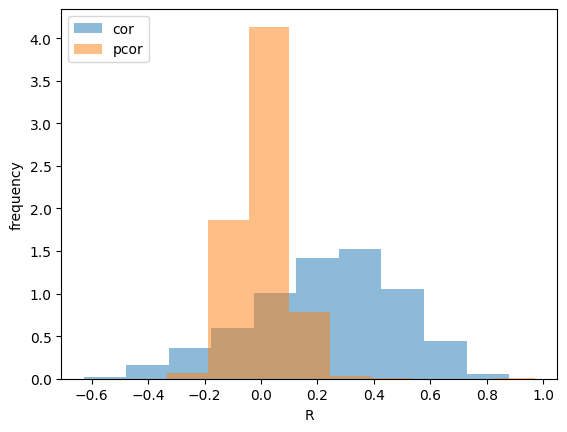

In [51]:
plt.hist(cor_values, density=True, alpha=0.5, label="cor")
plt.hist(pcor_values, density=True, alpha=0.5, label="pcor")
plt.legend(loc="upper left")
plt.xlabel("R")
plt.ylabel("frequency")
plt.show()

Fisher transform the partial correlation values, using `numpy.log`:

In [52]:
z_scores = 0.5*np.log((1+pcor_values)/
                      (1-pcor_values))

Compute a *p*-value for each gene pair (upper triangle only), using the fact that sqrt(*M*-*N*-5) times the fisher *Z* sore should be approximately univariate normal (with zero mean) under the null hypothesis that a given gene pair's measurements (conditioned on the measurements for all the other 162 genes) are independent. You will want to use `scipy.stats.norm.cdf`, `numpy.abs`, and `math.sqrt` function (see class session 13 exercise).

In [53]:
M = gene_matrix_for_network_df.shape[1]

P_values = 2.0*scipy.stats.norm.cdf(-np.abs(z_scores)*(math.sqrt((M-N-5))))

How many gene pairs have a *P* value-less than 0.01? (use `numpy.where` and `len`)

In [54]:
len(np.where(P_values < 0.01)[0])

706

What are the sizes of the components in the undirected graph whose edges have *P*&nbsp;<&nbsp;0.05 in the statistical test that you did?  You will need to use `zip`, `tolist`, `list`, and `igraph.Graph.TupleList` (see class session 13 exercise). Print the usual graph summary.

In [55]:
inds_tri = np.where(np.tri(*matrix_pcor.shape, k=-1))
inds_sig = np.where(P_values < 0.01)
graph_edge_list = list(zip(inds_tri[1][inds_sig].tolist(),
                           inds_tri[0][inds_sig].tolist()))
final_network = igraph.Graph.TupleList(graph_edge_list, directed=False)
final_network.summary()

'IGRAPH UN-- 164 706 -- \n+ attr: name (v)'

Plot the graph degree distribution on log-log scale (see HW 1 and Notebook 3).

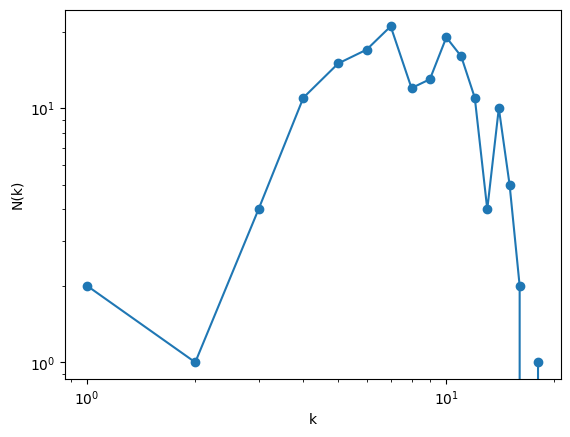

In [56]:
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
plt.loglog(xs, ys, marker="o")
plt.xlabel("k")
plt.ylabel("N(k)")
plt.show()
